## This notebook has the goal of making the Mixture of Factor Analyzers (MFA) model, along with benchmark models

The models are to be saved to a models-folder in the project. 
As a benchmark-model, PCA is to be used. Further benchmark-models might be added. 
Trainingtime for each model should be noted.

In [ ]:
import torch
import glob
import matplotlib.pyplot as plt
from MFA import MFA
from utils import get_data
from enum import Enum
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### fetching training-data
The training-data consists of a subsample of pixels taken from vastly different geographical places. The image was choosen to deliberatly include both water and land pixels for there to naturally be more classes for the model to describe. 

in "01_model_testing.ipynb", the trained models will be tested on new pixels.

In [2]:
class DataProduct(Enum):
    L1A = 'l1a'
    L1B = 'l1b'
    L1D = 'l1d'

class PreprocessingMethod(Enum):
    L2 = 'L2'
    MEAN_CENTERING = 'MeanCentering'

In [3]:
data_product = DataProduct.L1B 

PREPROCESSING_METHOD = PreprocessingMethod.L2 

In [5]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = glob.glob(f'data/training_{data_product.value}/*.nc')
print(f"Found {len(data_dir)} files.")

Using device: cpu
Found 44 files.


### Determine if we add spatial features
Tests have shown that adding spatial features (Convalutional operation of 3x3), the RMSE and SAM is massivly improved for the MFA. 
This improvement is not found with the PCA-model, and the reason as for why this is remains unclear.

In practice, this is done by performing a convolution operation on all pixels, and adding the average of each band as a new band. This increases the feature-size from 120 to 240.

In [ ]:
target_total_samples = 200000

data_list = get_data(data_dir, data_product, target_total_samples)

data = torch.from_numpy(data_list).float().to(device)

Aiming to extract ~4545 pixels per file from 44 files to reach a total of ~200000 samples.
0/44 | File: data/training_l1b\aeronetgalata_2025-01-02T08-18-16Z-l1b.nc | Extracted 4545 pixels.
1/44 | File: data/training_l1b\algeria_2022-10-29T09-44-03Z-l1b.nc | Extracted 4545 pixels.
2/44 | File: data/training_l1b\amazonia_2024-09-21T13-12-47Z-l1b.nc | Extracted 4545 pixels.
3/44 | File: data/training_l1b\annapolis_2025-08-04T15-25-40Z-l1b.nc | Extracted 4545 pixels.
4/44 | File: data/training_l1b\antarctica_2022-11-20T08-44-35Z-l1b.nc | Extracted 4545 pixels.
5/44 | File: data/training_l1b\barfire_2025-08-04T09-11-36Z-l1b.nc | Extracted 4545 pixels.
6/44 | File: data/training_l1b\bermuda_2024-07-16T14-27-21Z-l1b.nc | Extracted 4545 pixels.
7/44 | File: data/training_l1b\blacksea2_2024-07-21T07-40-44Z-l1b.nc | Extracted 4545 pixels.
8/44 | File: data/training_l1b\capedyer_2023-10-16T14-54-55Z-l1b.nc | Extracted 4545 pixels.
9/44 | File: data/training_l1b\capescott_2023-05-09T19-29-59Z-l1b.

## Look for outliers or dead pixels

Iterating over the pixels to see if any are all zero or all max

In [ ]:
# We check if ALL values along the last dimension (bands) are 0
dead_pixel_mask = (data == 0).all(dim=-1)

# Get the indices/coordinates of the dead pixels
dead_pixel_indices = torch.nonzero(dead_pixel_mask)

# Check how many dead pixels were found
print(f"Number of dead pixels: {dead_pixel_indices.shape[0]}")

Number of dead pixels: 0


## Making the MFA Model

### Model Selection
Determining the optimal model order—specifically the number of mixture components ($K$) and the dimensionality of the latent factor space ($q$)—is a critical step to prevent overfitting. The literature emphasizes two primary methods for this selection process:
1. **The Information Criteria Approach (BIC)**

Source: McLachlan, G., & Peel, D. (2000). *Finite Mixture Models.*

This approach involves performing a grid search over potential $(K, q)$ combinations. For each combination, we calculate the Bayesian Information Criterion (BIC) and select the pair with the lowest BIC score. This metric balances goodness-of-fit with model complexity:$$\text{BIC} = -2 \ln(\mathcal{L}) + d \ln(n)$$
Where:
$\mathcal{L}$ is the maximized likelihood of the model.
$d$ is the number of free parameters.
$n$ is the number of observations.

2. **The Variational Bayesian Approach (VB)**

Source: Ghahramani, Z., & Beal, M. J. (2000). *Variational Inference for Bayesian Mixtures of Factor Analysers.*

Unlike the BIC grid search, the Variational Bayesian method treats model selection as an integral part of the optimization process itself, rather than a post-hoc comparison.
Mechanism: It places Dirichlet priors on the mixing coefficients and Automatic Relevance Determination (ARD) priors on the factor loading matrices.
Result: As the model trains, it automatically drives the coefficients of unnecessary components or factors to zero, effectively selecting the model structure in a single run.

## Choosen approach
1. Perform PCA on the entire dataset. If a single PCA model can describe >99.5% of the variance with *N* number of components, then we set *N* as the ceiling for our BIC-method. Source: Bioucas-Dias, J. M., & Nascimento, J. M. (2008). *Hyperspectral Subspace Identification.*

2. Sample a subset of the pixels 10,000 - 50,000 pixels. Source: Banfield, J. D., & Raftery, A. E. (1993). *Model-Based Gaussian and Non-Gaussian Clustering.*

3. Perform the grid search on the sampled pixels. Plot the BIC-curves. 

4. Retrain the optimal combinantion on the complete dataset.

### 1. Make PCA-model

------------------------------
Cumulative Variance for top 10 components:
 tensor([0.9006, 0.9597, 0.9839, 0.9936, 0.9954, 0.9970, 0.9981, 0.9986, 0.9990,
        0.9993])
------------------------------
Number of components to explain 99.5% variance: 5
Ceiling for q (latent factors) set to: 5
PCA model saved to 'models/no_spatial/pca_benchmark_l1b.pt'


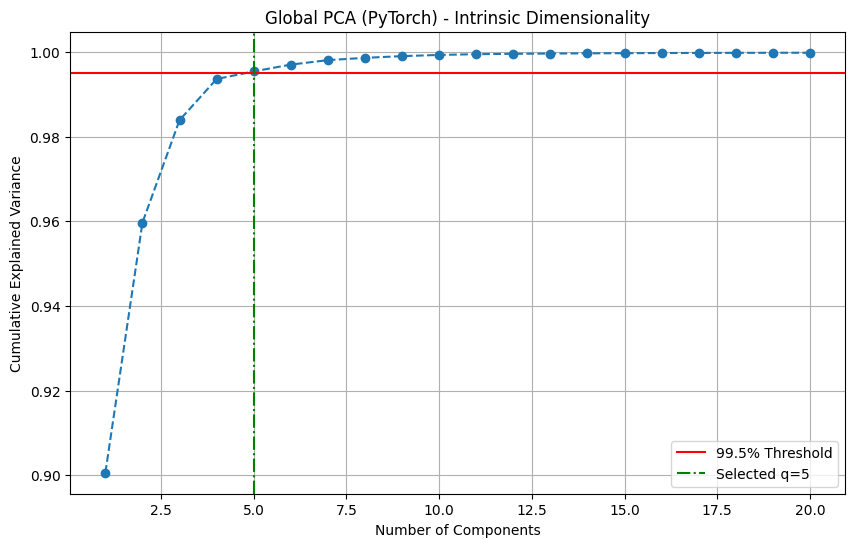

In [ ]:
# 1. Mean Centering
mean_vector = data.mean(dim=0)
X_centered = data - mean_vector

# 2. Compute Covariance Matrix
n_samples = X_centered.shape[0]
cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)

# 3. Eigendecomposition (PCA)
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

# 4. Sort indices in descending order (eigh returns ascending)
sorted_indices = torch.argsort(eigenvalues, descending=True)
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_components = eigenvectors[:, sorted_indices]

# 5. Calculate Cumulative Variance
total_variance = sorted_eigenvalues.sum()
explained_variance_ratio = sorted_eigenvalues / total_variance
cum_var = torch.cumsum(explained_variance_ratio, dim=0)

# 6. Find the threshold (99.5%)
threshold = 0.995
n_components_995 = (cum_var >= threshold).nonzero(as_tuple=False)[0].item() + 1

print("-" * 30)
print(f"Cumulative Variance for top 10 components:\n {cum_var[:10]}")
print("-" * 30)
print(f"Number of components to explain {threshold*100}% variance: {n_components_995}")
print(f"Ceiling for q (latent factors) set to: {n_components_995}")

# 7. Save the PCA Model
pca_state = {
    'components': sorted_components[:, :n_components_995], # Save only needed components
    'mean': mean_vector,
    'explained_variance': sorted_eigenvalues[:n_components_995],
    'n_components_995': n_components_995
}

torch.save(pca_state, f'models/{PREPROCESSING_METHOD.value}/pca_benchmark_{data_product}.pt')
print(f"PCA model saved to 'models/{PREPROCESSING_METHOD.value}/pca_benchmark_{data_product}.pt'")

# Move to CPU for plotting
cum_var_np = cum_var.cpu().numpy()
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), cum_var_np[:20], marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-', label=f'{threshold*100}% Threshold')
plt.axvline(x=n_components_995, color='g', linestyle='-.', label=f'Selected q={n_components_995}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Global PCA (PyTorch) - Intrinsic Dimensionality')
plt.legend()
plt.grid(True)
plt.show()

### 2. Subsample the dataset

In [ ]:
N_SUBSET = 50000 
torch.manual_seed(42)

# Generate random indices
if data.shape[0] > N_SUBSET:
    # random_split or randperm is standard torch practice
    indices = torch.randperm(data.shape[0])[:N_SUBSET]
    data_subset = data[indices]
    print(f"Subsampled data from {data.shape[0]} to {data_subset.shape[0]} samples.")
else:
    print("Dataset smaller than requested subset. Using full data.")
    data_subset = data

print(f"Subset shape: {data_subset.shape}")

Subsampled data from 199980 to 50000 samples.
Subset shape: torch.Size([50000, 120])


### Perform Log-Likelyhood Grid Search

We hold out 10% of the training-samples, and train the MFA on the remainding 90%. For each batch, we calculate the out-of-sample log-likelyhood of the model explaining the pixels. 

Starting Out-of-Sample Log-Likelihood Grid Search.
Training on 40000 samples, Testing on 10000 samples.
Training Max Value: 418.289306640625
Train Processed: Max=0.7839, Mean=-0.0000
Completed 1/28 - K=2, q=2, Test LL=349.8997
Completed 2/28 - K=2, q=3, Test LL=428.7385
Completed 3/28 - K=2, q=4, Test LL=459.5040
Completed 4/28 - K=2, q=5, Test LL=463.8440
Completed 5/28 - K=3, q=2, Test LL=407.2624
Completed 6/28 - K=3, q=3, Test LL=447.5248
Completed 7/28 - K=3, q=4, Test LL=470.3202
Completed 8/28 - K=3, q=5, Test LL=487.1274
Completed 9/28 - K=4, q=2, Test LL=428.4068
Completed 10/28 - K=4, q=3, Test LL=459.0783
Completed 11/28 - K=4, q=4, Test LL=472.5019
Completed 12/28 - K=4, q=5, Test LL=491.2394
Completed 13/28 - K=5, q=2, Test LL=428.5961
Completed 14/28 - K=5, q=3, Test LL=469.7419
Completed 15/28 - K=5, q=4, Test LL=481.8462
Completed 16/28 - K=5, q=5, Test LL=492.9562
Completed 17/28 - K=6, q=2, Test LL=446.1859
Completed 18/28 - K=6, q=3, Test LL=472.4513
Completed 19/28 

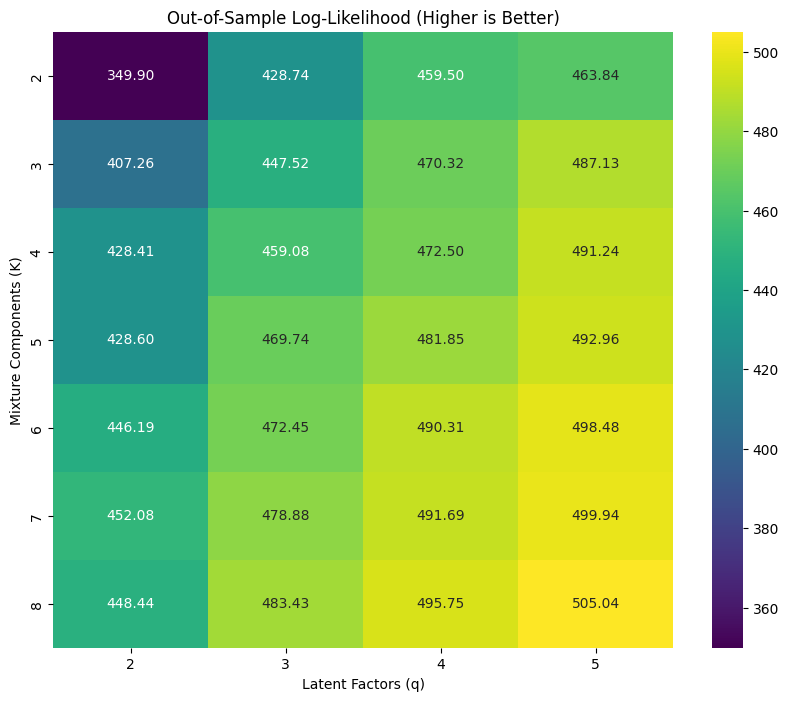

In [ ]:
torch.manual_seed(42)

# Grid Configuration
k_range = range(2, 9, 1)
# Calculate ceiling and add safety buffer (Assuming n_components_995 is defined earlier)
q_ceiling = max(n_components_995, 5) 
q_range = range(2, q_ceiling + 1) 

# --- 1. PROPER TRAIN/TEST SPLIT ---
train_size = int(0.8 * len(data_subset))
test_size = len(data_subset) - train_size
X_train_dataset, X_test_dataset = torch.utils.data.random_split(data_subset, [train_size, test_size])

# Extract the actual tensors from the Subset objects
X_train = data_subset[X_train_dataset.indices]
X_test = data_subset[X_test_dataset.indices]

print(f"Starting Out-of-Sample Log-Likelihood Grid Search.")
print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples.")

# --- 2. STRICT PREPROCESSING (No Data Leakage) ---
# We ONLY use X_train to calculate max and mean
train_max = X_train.max()
print(f"Training Max Value: {train_max}")

# Scale both using train_max
X_train_scaled = X_train / train_max
X_test_scaled = X_test / train_max

# Center both using train_mean
train_mean = X_train_scaled.mean(dim=0)
X_train_processed = (X_train_scaled - train_mean).float()
X_test_processed = (X_test_scaled - train_mean).float()

print(f"Train Processed: Max={X_train_processed.max():.4f}, Mean={X_train_processed.mean():.4f}")

# --- 3. THE GRID SEARCH LOOP ---
results_list = []
i = 1
total_iters = len(k_range) * len(q_range)

for k in k_range:
    for q in q_range:
        if q >= 120: 
            continue
            
        try: 
            # Initialize model
            model = MFA(n_components=k, n_features=X_train_processed.shape[1], n_factors=q, device=device)
            
            # Initialize and FIT ONLY ON TRAIN DATA
            model.initialize_parameters(X_train_processed)
            model.fit(X_train_processed)

            # --- CALCULATE OUT-OF-SAMPLE LOG-LIKELIHOOD ---
            with torch.no_grad(): # Don't track gradients for testing
                # We pass X_test_processed to the e_step to see how well it fits unseen data
                _, log_likelihood_per_pixel = model.e_step(X_test_processed)
                
                # FIX FOR YOUR ERROR: Average the likelihood across all test pixels to get a scalar
                out_of_sample_ll = log_likelihood_per_pixel.mean().item()
    
            results_list.append({'K': k, 'q': q, 'Test_Log_Likelihood': out_of_sample_ll})
            
            print(f"Completed {i}/{total_iters} - K={k}, q={q}, Test LL={out_of_sample_ll:.4f}")

            if device.type == 'cuda':
                torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"Failed for K={k}, q={q}: {e}")
            
        i += 1

# --- 4. VISUALIZATION ---
if len(results_list) > 0:
    results_df = pd.DataFrame(results_list)

    # Find optimal (For Log-Likelihood, HIGHER IS BETTER)
    best_row = results_df.loc[results_df['Test_Log_Likelihood'].idxmax()]
    print("-" * 30)
    print(f"Best Model configuration: K={int(best_row['K'])}, q={int(best_row['q'])}")
    print("-" * 30)

    # Pivot for Heatmap
    ll_pivot = results_df.pivot(index="K", columns="q", values="Test_Log_Likelihood")

    plt.figure(figsize=(10, 8)) 
    # Use standard viridis. HIGHER is better, so the brightest yellow is your best model.
    sns.heatmap(ll_pivot, annot=True, fmt=".2f", cmap="viridis") 
    
    plt.title("Out-of-Sample Log-Likelihood (Higher is Better)")
    plt.xlabel("Latent Factors (q)")
    plt.ylabel("Mixture Components (K)")
    plt.show()

    K_optimal = int(best_row['K'])
    q_optimal = int(best_row['q'])
else:
    print("No results to plot.")

### Retrain the model on the complete dataset 

In [ ]:
data_max = data.max()
print(f"Original Max Value: {data_max}")
X_scaled = data / data_max 

mean = X_scaled.mean(dim=0)
X_processed = X_scaled - mean

# Ensure float32
X_processed = X_processed.float()
print(f"Shape of X_processed: {X_processed.shape}")

#Parameters found above
K = K_optimal
q = q_optimal
model = MFA(n_components=K, n_features=X_processed.shape[1], n_factors=q, device=device)

model.initialize_parameters(X_processed)

# Fit
model.fit(X_processed)
# Calculate BIC
BIC_score = model.bic(X_processed)
# Clean up memory if using GPU
if device.type == 'cuda':
    torch.cuda.empty_cache()

# Save model

mfa_state = {
    # -- Model Parameters --
    # model.state_dict() automatically grabs log_pi, mu, Lambda, log_psi
    'model_state_dict': model.state_dict(), 
    
    # -- Hyperparameters (Required to re-initialize the class) --
    'hyperparameters': {
        'n_components': K,
        'n_features': X_processed.shape[1],
        'n_factors': q
    },
    
    # -- Preprocessing Stats (CRITICAL for inference) --
    'preprocessing': {
        'data_max': data_max, # From your normalization step
        'mean': mean          # From your centering step
    },
    
    # -- Metadata --
    'metrics': {
        'bic': BIC_score,
        'final_ll': getattr(model, 'final_ll', None)
    }
}

# 2. Save to file
if ADD_SPATIAL_INFO:
    spatial_str = "spatial"
else:
    spatial_str = "no_spatial"

save_path = f'models/{spatial_str}/mfa_k{K}_q{q}_{data_product}.pt'
torch.save(mfa_state, save_path)
print(f"MFA model saved to '{save_path}'")

Shape of X_processed: torch.Size([199980, 120])
Norms of first 5 pixels: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Shape of X_processed: torch.Size([199980, 120])
MFA model saved to 'models/no_spatial/mfa_k6_q3_l1b.pt'
